In [2]:
import wandb
import math
import torch
import torchcde
from tqdm import tqdm
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt
import os
from pathlib import Path
from scipy.io import loadmat 
import time 
from model import *
from data import *

In [ ]:
# Load Pretrained Model - 1: NCDE, 2: MLP
model = NeuralCDE(input_channels=2, hidden_channels=3, output_channels=3)
model = model.cuda()
model.load_state_dict(torch.load('/mnt/vol6t/Projects/NeuralCDE/T1_mapping/scripts/wandb/run-20230504_171827-94mjf1q9/files/model.pt'))

model_2 = MLP(input_channels=22, hidden_channels=128, output_channels=3)
model_2 = model_2.cuda()
model_2.load_state_dict(torch.load('/mnt/vol6t/Projects/NeuralCDE/T1_mapping/scripts/wandb/run-20230515_140834-8sddtv91/files/model_at_epoch_86.pt'))

In [2]:
def get_data_stack(data):
    data_tensor = torch.Tensor(data['volume'].astype(np.float32))
    time_tensor = torch.Tensor(data['tvec'].astype(np.float32))
    time_tensor_unsorted = time_tensor.clone()
    # now add sorting
    time_tensor, index = torch.sort(time_tensor)
    data_tensor = data_tensor[:,:,index]

    data_reshaped = data_tensor.reshape(-1,11)
    X_test = torch.stack([time_tensor.unsqueeze(0).repeat(data_tensor.shape[0]* data_tensor.shape[1], 1), data_reshaped], dim=2)
    return X_test, time_tensor_unsorted, data_reshaped

In [3]:
# Load Test Data and Label Data
# test data loading
#dat = loadmat('MAVI102_20151026_pre1.mat') 

image_name = '2980827_20140416_MOLLI_pre_groupwise.mat'
image_slice = 1

data_Yi = loadmat_wrapper_with_contour_org('/mnt/vol6t/Projects/NeuralCDE/T1_mapping/registered_dataset/'+image_name,image_slice)

X_test,time_tensor_unsorted, data_reshaped = get_data_stack(data_Yi)

# Inference

In [ ]:
#X_test = torch.stack([time_tensor.unsqueeze(0).repeat(data_tensor.shape[0]* data_tensor.shape[1], 1), data_reshaped], dim=2)

fitted_params = torch.Tensor(np.load(f'/mnt/vol6t/Projects/curve_fit/PyMC/output_data/{image_name}_slice_{image_slice}.npy'))
fitted_params = fitted_params.reshape(-1, 3)
######################
# Validation
######################
test_X = X_test
test_y = fitted_params
test_X_norm = test_X/torch.Tensor([1000,100])
#test_y_norm = test_y/torch.Tensor([100,1,1000])
#test_time_norm = test_time/1000

text_X_norm_mlp = test_X_norm.reshape(-1,22)
print(text_X_norm_mlp.shape)
model.eval()

test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(test_X_norm)
test_coeffs = test_coeffs.cuda()
test_y = test_y.cuda()

test_dataset = torch.utils.data.TensorDataset(test_coeffs, test_y)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8192)

test_dataset_mlp = torch.utils.data.TensorDataset(text_X_norm_mlp.cuda(), test_y)
test_dataloader_mlp = torch.utils.data.DataLoader(test_dataset_mlp, batch_size=8192)

val_loss = []
val_prediction = []
for batch in tqdm(test_dataloader):
    batch_coeffs, batch_y, = batch
    batch_coeffs = batch_coeffs.cuda()
    batch_y = batch_y.cuda()
    pred_y = model(batch_coeffs).squeeze(-1)
    loss = nn.functional.l1_loss(pred_y, batch_y)
    # rescale pred_y to the original scale
    pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
    val_prediction.append(pred_y)
    val_loss.append(loss.item())

val_prediction = torch.cat(val_prediction, dim=0)[:,2]
val_prediction = val_prediction.cpu().detach().numpy()
val_loss = np.array(val_loss)
print(val_loss.mean())

val_loss = []
val_prediction_mlp = []
for batch in tqdm(test_dataloader_mlp):
    batch_x, batch_y, = batch
    batch_x = batch_x.cuda()
    batch_y = batch_y.cuda()
    pred_y = model_2(batch_x).squeeze(-1)
    loss = nn.functional.l1_loss(pred_y, batch_y)
    # rescale pred_y to the original scale
    pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
    val_prediction_mlp.append(pred_y)
    val_loss.append(loss.item())

val_prediction_mlp = torch.cat(val_prediction_mlp, dim=0)[:,2]
val_prediction_mlp = val_prediction_mlp.cpu().detach().numpy()
val_loss = np.array(val_loss)
print(val_loss.mean())

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=300)
fig.suptitle(f'T1 Mapping', x = 0.56, y = 0.7)
im = ax1.imshow(fitted_params.reshape(200,200,3)[:,:,2], vmin=200, vmax=2e3, cmap='jet')
ax1.set_title('LS - T1 (ms)', y = -0.2)
ax1.axis('off')

plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax2.imshow(val_prediction_mlp.reshape(200,200), cmap='jet', vmin=200, vmax=2e3)
ax2.axis('off')
ax2.set_title('MLP - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax3.imshow(val_prediction.reshape(200,200), cmap='jet', vmin=200, vmax=2e3)
ax3.axis('off')
ax3.set_title('NCDE - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

fig.tight_layout()

# Noise Resistency

In [ ]:
data_tensor = torch.Tensor(data_Yi['volume'].astype(np.float32))
time_tensor = torch.Tensor(data_Yi['tvec'].astype(np.float32))
time_tensor_unsorted = time_tensor.clone()
# now add sorting
time_tensor, index = torch.sort(time_tensor)
data_tensor = data_tensor[:,:,index]

data_reshaped = data_tensor.reshape(-1,11)
X_test = torch.stack([time_tensor.unsqueeze(0).repeat(data_tensor.shape[0]* data_tensor.shape[1], 1), data_reshaped], dim=2)


In [ ]:
index

In [ ]:
# Test
for i in range(2
               ):
    print('now the perturabation std is ', (i+1)*5)
    data_reshaped_perturbed = data_reshaped + torch.randn_like(data_reshaped) * 5*(i+1)
    #test_X = data_reshaped_perturbed
    X_test = torch.stack([time_tensor.unsqueeze(0).repeat(data_tensor.shape[0]* data_tensor.shape[1], 1), data_reshaped_perturbed], dim=2)

    fitted_params = torch.Tensor(np.load(f'/mnt/vol6t/Projects/curve_fit/PyMC/output_data_perturb/2980827_20140416_MOLLI_pre_groupwise.mat_slice_1_perturb_{5*(i+1)}.npy'))
    fitted_params = fitted_params.reshape(-1, 3)
    ######################
    # Validation
    ######################
    test_X = X_test
    test_y = fitted_params
    test_X_norm = test_X/torch.Tensor([1000,100])
    #test_y_norm = test_y/torch.Tensor([100,1,1000])
    #test_time_norm = test_time/1000

    model.eval()

    test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(test_X_norm)
    test_coeffs = test_coeffs.cuda()
    test_y = test_y.cuda()
    
    test_dataset = torch.utils.data.TensorDataset(test_coeffs, test_y)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2048)

    text_X_norm_mlp = test_X_norm.reshape(-1,22)
    test_dataset_mlp = torch.utils.data.TensorDataset(text_X_norm_mlp.cuda(), test_y)
    test_dataloader_mlp = torch.utils.data.DataLoader(test_dataset_mlp, batch_size=8192)



    val_loss = []
    val_prediction = []
    for batch in tqdm(test_dataloader):
        batch_coeffs, batch_y, = batch
        batch_coeffs = batch_coeffs.cuda()
        batch_y = batch_y.cuda()
        pred_y = model(batch_coeffs).squeeze(-1)
        # rescale pred_y to the original scale
        pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
        val_prediction.append(pred_y)

    val_prediction = torch.cat(val_prediction, dim=0)[:,2]
    val_prediction = val_prediction.cpu().detach().numpy()

    val_loss = []
    val_prediction_mlp = []
    for batch in tqdm(test_dataloader_mlp):
        batch_x, batch_y, = batch
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        pred_y = model_2(batch_x).squeeze(-1)
        loss = nn.functional.l1_loss(pred_y, batch_y)
        # rescale pred_y to the original scale
        pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
        val_prediction_mlp.append(pred_y)
        val_loss.append(loss.item())
    val_prediction_mlp = torch.cat(val_prediction_mlp, dim=0)[:,2]
    val_prediction_mlp = val_prediction_mlp.cpu().detach().numpy()

    ######################
    # Plotting
    ######################
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=300)
    fig.suptitle(f'T1 Mapping at Gaussian Noise Level {(i+1)*5}', x = 0.56, y = 0.72)
    im = ax1.imshow(fitted_params.reshape(256,256,3)[:,:,2], vmin=200, vmax=2e3, cmap='jet')
    ax1.set_title('LS - T1 (ms)', y = -0.2)
    ax1.axis('off')

    plt.colorbar(im, fraction=0.040, pad=0.025)

    im = ax2.imshow(val_prediction_mlp.reshape(256,256), cmap='jet', vmin=200, vmax=2e3)
    ax2.axis('off')
    ax2.set_title('MLP - T1 (ms)', y = -0.2)
    plt.colorbar(im, fraction=0.040, pad=0.025)

    im = ax3.imshow(val_prediction.reshape(256,256), cmap='jet', vmin=200, vmax=2e3)
    ax3.axis('off')
    ax3.set_title('NCDE - T1 (ms)', y = -0.2)
    plt.colorbar(im, fraction=0.040, pad=0.025)


    fig.tight_layout()
    #plt.show()
    plt.savefig(f'/mnt/vol6t/Projects/NeuralCDE/T1_mapping/figures/noise_gaussian/MAVI102_20151026_pre1.mat_slice_1_perturb_{5*(i+1)}.png')

    #plt.savefig(f'/figures/{image_name}_perturb_{(i+1)*5}.png')
    #plt.close()
    val_loss = np.array(val_loss)
    ######################
    # Logging
    ######################

    #wandb.log({'validation_figure_with_noisy_signals': fig})
    #wandb.log({"noise_level": i})


    #torch.save(model.state_dict(), f'./model_{epoch}.pth')

In [ ]:
import imageio
frames = []
for t in range(-1,20):
    image = imageio.v2.imread(f'/mnt/vol6t/Projects/NeuralCDE/T1_mapping/figures/noise_gaussian/MAVI102_20151026_pre1.mat_slice_1_perturb_{5*(t+1)}.png')
    frames.append(image)

In [ ]:
imageio.mimsave('./example_extended.gif', # output gif
                frames,          # array of input frames
                fps = 3)         # optional: frames per second

In [ ]:
print(zip(1 for _ in range(3)))


# Partial Observation - Shortened

In [ ]:
# Load Pretrained Model - 1: NCDE trained with varied length from 3 to 11
model = NeuralCDE(input_channels=2, hidden_channels=8, output_channels=3)
model = model.cuda()
model.load_state_dict(torch.load('/mnt/vol6t/Projects/NeuralCDE/T1_mapping/scripts/wandb/run-20230502_134151-58759brs/files/model.pt'))
model.eval()

In [ ]:
def fill_forward(x):
    return torch.cat([x, x[-1].unsqueeze(0).expand(11 - x.size(0), x.size(1))])

In [ ]:
text_X_norm_extend = torch.zeros((test_X_norm.shape[0], 11, 2))
for i in tqdm(range(test_X_norm.shape[0])):
    text_X_norm_extend[i] = fill_forward(test_X_norm[i])

In [ ]:
X_test = torch.stack([time_tensor.unsqueeze(0).repeat(data_tensor.shape[0]* data_tensor.shape[1], 1), data_reshaped], dim=2)

fitted_params = torch.Tensor(np.load(f'/mnt/vol6t/Projects/curve_fit/PyMC/output_data/{image_name}_slice_{image_slice}.npy'))
fitted_params = fitted_params.reshape(-1, 3)
######################
# Validation
######################
test_X = X_test
test_y = fitted_params
test_X_norm = test_X/torch.Tensor([1000,100])
#test_y_norm = test_y/torch.Tensor([100,1,1000])
#test_time_norm = test_time/1000

text_X_norm_mlp = test_X_norm.reshape(-1,22)
test_X_norm = test_X_norm[:,[0,1,2,3,4,6,10],:]
print(text_X_norm_mlp.shape)
model.eval()

In [ ]:
#X_test = torch.stack([time_tensor.unsqueeze(0).repeat(data_tensor.shape[0]* data_tensor.shape[1], 1), data_reshaped], dim=2)

fitted_params = torch.Tensor(np.load(f'/mnt/vol6t/Projects/curve_fit/PyMC/output_data/{image_name}_slice_{image_slice}.npy'))
fitted_params = fitted_params.reshape(-1, 3)
######################
# Validation
######################
test_X = X_test
test_y = fitted_params
test_X_norm = test_X/torch.Tensor([1000,100])
#test_y_norm = test_y/torch.Tensor([100,1,1000])
#test_time_norm = test_time/1000

text_X_norm_mlp = test_X_norm.reshape(-1,22)
test_X_norm = test_X_norm[:,[0,1,3,4,6],:]
print(text_X_norm_mlp.shape)
model.eval()
text_X_norm_extend = torch.zeros((test_X_norm.shape[0], 11, 2))
for i in tqdm(range(test_X_norm.shape[0])):
    text_X_norm_extend[i] = fill_forward(test_X_norm[i])

test_coeffs_extend = torchcde.hermite_cubic_coefficients_with_backward_differences(text_X_norm_extend)
test_coeffs_extend = test_coeffs_extend.cuda()

test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(test_X_norm)
test_coeffs = test_coeffs.cuda()

test_y = test_y.cuda()

test_dataset = torch.utils.data.TensorDataset(test_coeffs, test_y)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8192)

test_dataset_extend = torch.utils.data.TensorDataset(test_coeffs_extend, test_y)
test_dataloader_extend = torch.utils.data.DataLoader(test_dataset_extend, batch_size=8192)

test_dataset_mlp = torch.utils.data.TensorDataset(text_X_norm_extend.reshape(-1,22).cuda(), test_y)
test_dataloader_mlp = torch.utils.data.DataLoader(test_dataset_mlp, batch_size=8192)

val_loss = []
val_prediction = []
for batch in tqdm(test_dataloader):
    batch_coeffs, batch_y, = batch
    batch_coeffs = batch_coeffs.cuda()
    batch_y = batch_y.cuda()
    pred_y = model(batch_coeffs).squeeze(-1)
    loss = nn.functional.l1_loss(pred_y, batch_y)
    # rescale pred_y to the original scale
    pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
    val_prediction.append(pred_y)
    val_loss.append(loss.item())

val_prediction = torch.cat(val_prediction, dim=0)[:,2]
val_prediction = val_prediction.cpu().detach().numpy()
val_loss = np.array(val_loss)
print(val_loss.mean())

val_loss = []
val_prediction_extend = []
for batch in tqdm(test_dataloader_extend):
    batch_coeffs, batch_y, = batch
    batch_coeffs = batch_coeffs.cuda()
    batch_y = batch_y.cuda()
    pred_y = model(batch_coeffs).squeeze(-1)
    loss = nn.functional.l1_loss(pred_y, batch_y)
    # rescale pred_y to the original scale
    pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
    val_prediction_extend.append(pred_y)
    val_loss.append(loss.item())

val_prediction_extend = torch.cat(val_prediction_extend, dim=0)[:,2]
val_prediction_extend = val_prediction_extend.cpu().detach().numpy()
val_loss = np.array(val_loss)
print(val_loss.mean())


val_loss = []
val_prediction_mlp = []
for batch in tqdm(test_dataloader_mlp):
    batch_x, batch_y, = batch
    batch_x = batch_x.cuda()
    batch_y = batch_y.cuda()
    pred_y = model_2(batch_x).squeeze(-1)
    loss = nn.functional.l1_loss(pred_y, batch_y)
    # rescale pred_y to the original scale
    pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
    val_prediction_mlp.append(pred_y)
    val_loss.append(loss.item())

val_prediction_mlp = torch.cat(val_prediction_mlp, dim=0)[:,2]
val_prediction_mlp = val_prediction_mlp.cpu().detach().numpy()
val_loss = np.array(val_loss)
print(val_loss.mean())

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=300)
fig.suptitle(f'T1 Mapping', x = 0.56, y = 0.7)
im = ax1.imshow(fitted_params.reshape(200,200,3)[:,:,2], vmin=200, vmax=2e3, cmap='jet')
ax1.set_title('LS - T1 (ms)', y = -0.2)
ax1.axis('off')

plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax2.imshow(val_prediction_mlp.reshape(200,200), cmap='jet', vmin=200, vmax=2e3)
ax2.axis('off')
ax2.set_title('MLP - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax3.imshow(val_prediction.reshape(200,200), cmap='jet', vmin=200, vmax=2e3)
ax3.axis('off')
ax3.set_title('NCDE - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

fig.tight_layout()

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=300)
fig.suptitle(f'T1 Mapping: First 5 Acquisitions', x = 0.56, y = 0.7)
im = ax1.imshow(fitted_params.reshape(200,200,3)[:,:,2], vmin=200, vmax=2e3, cmap='jet')
ax1.set_title('LS - T1 (ms)', y = -0.2)
ax1.axis('off')

plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax2.imshow(val_prediction_extend.reshape(200,200), cmap='jet', vmin=200, vmax=2e3)
ax2.axis('off')
ax2.set_title('NCDE - data extended - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax3.imshow(val_prediction.reshape(200,200), cmap='jet', vmin=200, vmax=2e3)
ax3.axis('off')
ax3.set_title('NCDE - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

fig.tight_layout()

# Irregular Observations

In [ ]:
# Load Test Data and Label Data
# test data loading
#dat = loadmat('MAVI102_20151026_pre1.mat') 

image_name = 'MAVI103_20151030_pre1.mat'
image_slice = 0

data_Yi = loadmat_wrapper_Yi('/mnt/vol6t/Projects/NeuralCDE/T1_mapping/MOLLI4Yi/'+image_name,image_slice)

X_test,time_tensor_unsorted,_ = get_data_stack(data_Yi)

In [ ]:
# reference time for calculating the difference
ref_t = torch.tensor([ 114., 1043, 1991,  232, 1187, 2145,  350, 1301, 2245, 3211, 4190])
abs((time_tensor_unsorted - ref_t)).mean()

In [ ]:
#X_test = torch.stack([time_tensor.unsqueeze(0).repeat(data_tensor.shape[0]* data_tensor.shape[1], 1), data_reshaped], dim=2)

fitted_params = torch.Tensor(np.load(f'/mnt/vol6t/Projects/curve_fit/PyMC/output_data/{image_name}_slice_{image_slice}.npy'))
fitted_params = fitted_params.reshape(-1, 3)
######################
# Validation
######################
test_X = X_test
test_y = fitted_params
test_X_norm = test_X/torch.Tensor([1000,100])
#test_y_norm = test_y/torch.Tensor([100,1,1000])
#test_time_norm = test_time/1000

text_X_norm_mlp = test_X_norm.reshape(-1,22)
print(text_X_norm_mlp.shape)
model.eval()

test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(test_X_norm)
test_coeffs = test_coeffs.cuda()
test_y = test_y.cuda()

test_dataset = torch.utils.data.TensorDataset(test_coeffs, test_y)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8192)

test_dataset_mlp = torch.utils.data.TensorDataset(text_X_norm_mlp.cuda(), test_y)
test_dataloader_mlp = torch.utils.data.DataLoader(test_dataset_mlp, batch_size=8192)

val_loss = []
val_prediction = []
for batch in tqdm(test_dataloader):
    batch_coeffs, batch_y, = batch
    batch_coeffs = batch_coeffs.cuda()
    batch_y = batch_y.cuda()
    pred_y = model(batch_coeffs).squeeze(-1)
    loss = nn.functional.l1_loss(pred_y, batch_y)
    # rescale pred_y to the original scale
    pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
    val_prediction.append(pred_y)
    val_loss.append(loss.item())

val_prediction = torch.cat(val_prediction, dim=0)[:,2]
val_prediction = val_prediction.cpu().detach().numpy()
val_loss = np.array(val_loss)
print(val_loss.mean())

val_loss = []
val_prediction_mlp = []
for batch in tqdm(test_dataloader_mlp):
    batch_x, batch_y, = batch
    batch_x = batch_x.cuda()
    batch_y = batch_y.cuda()
    pred_y = model_2(batch_x).squeeze(-1)
    loss = nn.functional.l1_loss(pred_y, batch_y)
    # rescale pred_y to the original scale
    pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
    val_prediction_mlp.append(pred_y)
    val_loss.append(loss.item())

val_prediction_mlp = torch.cat(val_prediction_mlp, dim=0)[:,2]
val_prediction_mlp = val_prediction_mlp.cpu().detach().numpy()
val_loss = np.array(val_loss)
print(val_loss.mean())

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=300)
fig.suptitle(f'T1 Mapping', x = 0.56, y = 0.7)
im = ax1.imshow(fitted_params.reshape(200,200,3)[:,:,2], vmin=200, vmax=2e3, cmap='jet')
ax1.set_title('LS - T1 (ms)', y = -0.2)
ax1.axis('off')

plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax2.imshow(val_prediction_mlp.reshape(200,200), cmap='jet', vmin=200, vmax=2e3)
ax2.axis('off')
ax2.set_title('MLP - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax3.imshow(val_prediction.reshape(200,200), cmap='jet', vmin=200, vmax=2e3)
ax3.axis('off')
ax3.set_title('NCDE - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

fig.tight_layout()

# Motion

To simulate the motion, we need to work back on image for some frames before reshape them into a vector...

In [ ]:
plt.imshow(data_tensor[:,:,0], cmap='gray')

We can then shift this frame with chosen direction and magnitude using affine function in pytorch

In [ ]:
import torchvision

In [ ]:
angle = 0
translate = [10,10]
torchvision.transforms.functional.affine(data_tensor[:,:,0],angle, translate,1,0)

# Random Sample

In [ ]:
import random

In [ ]:
t = torch.linspace(0, 1, 10)

In [ ]:
perm = torch.randperm(t.size(0))
print(perm)
perm = perm[:torch.randint(3,11,(1,))]
t_sampled = t[perm]
print(t_sampled.sort()[0])

# Quantitative Metrics: Myocardium

In [ ]:
import glob

In [ ]:

# generate inference data numpy
data_root = '/mnt/vol6t/Projects/NeuralCDE/T1_mapping/registered_dataset'
data_files = glob.glob(data_root + '/*pre*_org.pt')
data = torch.load(data_files[16])
masked_T1 = np.ma.masked_array(data['T1'], mask = 1-data['mask'].astype('int'), fill_value= 0)

In [ ]:
fig, ax = plt.subplots()
plt.imshow(masked_T1.filled(fill_value=0), cmap='jet', vmin=200, vmax=2e3)
fig.set_facecolor('lightgray')
plt.colorbar()

In [ ]:
plt.imshow(data['T1'], cmap='jet', vmin=0, vmax=2000)
plt.colorbar()
x = [point[0] for point in data['outer_contour']]
y = [point[1] for point in data['outer_contour']]

# Plot the contour
plt.plot(x, y)

x = [point[0] for point in data['inner_contour']]
y = [point[1] for point in data['inner_contour']]

# Plot the contour
plt.plot(x, y)

In [ ]:
X_test,time_tensor_unsorted, data_reshaped = get_data_stack(data)

In [ ]:
nonzero_indices = np.nonzero(data['T1'])
top = np.min(nonzero_indices[0])
bottom = np.max(nonzero_indices[0])
left = np.min(nonzero_indices[1])
right = np.max(nonzero_indices[1])
height = bottom - top + 1
width = right - left + 1

# Compute the center crop dimensions
crop_size = min(height, width)
crop_top = top + (height - crop_size) // 2
crop_bottom = crop_top + crop_size - 1
crop_left = left + (width - crop_size) // 2
crop_right = crop_left + crop_size - 1

In [ ]:
#X_test = torch.stack([time_tensor.unsqueeze(0).repeat(data_tensor.shape[0]* data_tensor.shape[1], 1), data_reshaped], dim=2)

fitted_params = torch.Tensor(data['T1'])
fitted_params = fitted_params.reshape(-1)
######################
# Validation
######################
test_X = X_test
test_y = fitted_params
test_X_norm = test_X/torch.Tensor([1000,100])
#test_y_norm = test_y/torch.Tensor([100,1,1000])
#test_time_norm = test_time/1000

text_X_norm_mlp = test_X_norm.reshape(-1,22)
print(text_X_norm_mlp.shape)
model.eval()

test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(test_X_norm)
test_coeffs = test_coeffs.cuda()
test_y = test_y.cuda()

test_dataset = torch.utils.data.TensorDataset(test_coeffs, test_y)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8192)

test_dataset_mlp = torch.utils.data.TensorDataset(text_X_norm_mlp.cuda(), test_y)
test_dataloader_mlp = torch.utils.data.DataLoader(test_dataset_mlp, batch_size=8192)

val_loss = []
val_prediction = []
for batch in tqdm(test_dataloader):
    batch_coeffs, batch_y, = batch
    batch_coeffs = batch_coeffs.cuda()
    batch_y = batch_y.cuda()
    pred_y = model(batch_coeffs).squeeze(-1)
    loss = nn.functional.l1_loss(pred_y[:,2], batch_y)
    # rescale pred_y to the original scale
    pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
    val_prediction.append(pred_y)
    val_loss.append(loss.item())

val_prediction = torch.cat(val_prediction, dim=0)[:,2]
val_prediction = val_prediction.cpu().detach().numpy()
val_loss = np.array(val_loss)
print(val_loss.mean())

val_loss = []
val_prediction_mlp = []
for batch in tqdm(test_dataloader_mlp):
    batch_x, batch_y, = batch
    batch_x = batch_x.cuda()
    batch_y = batch_y.cuda()
    pred_y = model_2(batch_x).squeeze(-1)
    loss = nn.functional.l1_loss(pred_y[:,2], batch_y)
    # rescale pred_y to the original scale
    pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
    val_prediction_mlp.append(pred_y)
    val_loss.append(loss.item())

val_prediction_mlp = torch.cat(val_prediction_mlp, dim=0)[:,2]
val_prediction_mlp = val_prediction_mlp.cpu().detach().numpy()
val_loss = np.array(val_loss)
print(val_loss.mean())

# arrange mask for visualization and real evaluation

val_prediction_mlp = val_prediction_mlp.reshape(data['T1'].shape[0],data['T1'].shape[1])
masked_mlp = np.ma.masked_array(val_prediction_mlp, mask = 1-data['T1'].astype('bool'), fill_value= 0)[crop_top:crop_bottom+1, crop_left:crop_right+1]
masked_mlp_myo = np.ma.masked_array(val_prediction_mlp, mask = 1-data['mask'].astype('int'), fill_value= 0)[crop_top:crop_bottom+1, crop_left:crop_right+1]

val_prediction = val_prediction.reshape(data['T1'].shape[0],data['T1'].shape[1])
masked_ncde = np.ma.masked_array(val_prediction, mask = 1-data['T1'].astype('bool'), fill_value= 0)[crop_top:crop_bottom+1, crop_left:crop_right+1]
masked_ncde_myo = np.ma.masked_array(val_prediction, mask = 1-data['mask'].astype('int'), fill_value= 0)[crop_top:crop_bottom+1, crop_left:crop_right+1]

masked_T1_myo = np.ma.masked_array(data['T1'], mask = 1-data['mask'].astype('int'), fill_value= 0)[crop_top:crop_bottom+1, crop_left:crop_right+1]



In [ ]:
nonzero_indices = np.nonzero(data['T1'])
top = np.min(nonzero_indices[0])
bottom = np.max(nonzero_indices[0])
left = np.min(nonzero_indices[1])
right = np.max(nonzero_indices[1])
height = bottom - top + 1
width = right - left + 1

# Compute the center crop dimensions
crop_size = min(height, width)
crop_top = top + (height - crop_size) // 2
crop_bottom = crop_top + crop_size - 1
crop_left = left + (width - crop_size) // 2
crop_right = crop_left + crop_size - 1

# Crop the image
#cropped_image = image[crop_top:crop_bottom+1, crop_left:crop_right+1]


## Metrics and Visualization

In [ ]:
diff_myo_ls_mlp = abs(masked_mlp_myo - masked_T1_myo)
diff_myo_ls_ncde = abs(masked_ncde_myo - masked_T1_myo)
T1_ls_mean = masked_T1_myo.mean()
T1_mlp_mean = masked_mlp_myo.mean()
T1_ncde_mean = masked_ncde_myo.mean()
T1_ls_sd = masked_T1_myo.std()
T1_mlp_sd = masked_mlp_myo.std()
T1_ncde_sd = masked_ncde_myo.std()
print(T1_ls_mean, T1_mlp_mean, T1_ncde_mean)
print(T1_ls_sd, T1_mlp_sd, T1_ncde_sd)

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=300)
fig.suptitle(f'T1 Mapping - Myocardium Only - Contour2_org', y = 0.67)
im = ax1.imshow(masked_T1_myo.filled(0), vmin=200, vmax=2e3, cmap='jet')
ax1.set_title(f'LS - T1 (ms) \n mean = {masked_T1_myo.mean():.2f}', y = -0.3, fontsize = 9)
ax1.axis('off')

plt.colorbar(im, fraction=0.045, pad=0.025)

im = ax2.imshow(masked_mlp_myo.filled(0), cmap='jet', vmin=200, vmax=2e3)
ax2.axis('off')
ax2.set_title(f'MLP - T1 (ms) \n mean = {masked_mlp_myo.mean():.2f}', y = -0.3, fontsize = 9)
plt.colorbar(im, fraction=0.045, pad=0.025)

im = ax3.imshow(masked_ncde_myo.filled(0), cmap='jet', vmin=200, vmax=2e3)
ax3.axis('off')
ax3.set_title(f'NCDE - T1 (ms) \n mean = {masked_ncde_myo.mean():.2f}', y = -0.3, fontsize = 9)
plt.colorbar(im, fraction=0.045, pad=0.025)

fig.tight_layout()

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=300)
fig.suptitle(f'T1 Mapping', y = 0.65)
im = ax1.imshow(data['T1'][crop_top:crop_bottom+1, crop_left:crop_right+1], vmin=200, vmax=2e3, cmap='jet')
x = [point[0]-crop_left for point in data['outer_contour']]
y = [point[1]-crop_top for point in data['outer_contour']]

# Plot the contour
im1 = ax1.plot(x, y,color = 'green')

x = [point[0]-crop_left for point in data['inner_contour']]
y = [point[1]-crop_top for point in data['inner_contour']]

# Plot the contour
im2 = ax1.plot(x, y, color = 'red')
ax1.set_title('LS - T1 (ms)', y = -0.2)
ax1.axis('off')

plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax2.imshow(masked_mlp.filled(0), cmap='jet', vmin=200, vmax=2e3)
ax2.axis('off')
ax2.set_title('MLP - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax3.imshow(masked_ncde.filled(0), cmap='jet', vmin=200, vmax=2e3)
ax3.axis('off')
ax3.set_title('NCDE - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

fig.tight_layout()

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=300)
fig.suptitle(f'T1 Mapping Difference - Myocardium Only \n', y = 0.65)
im = ax1.imshow(masked_T1_myo.filled(0), vmin=200, vmax=2e3, cmap='jet')
ax1.set_title(f'LS - T1 (ms) \n mean = {masked_T1_myo.mean():.2f}', y = -0.3, fontsize = 9)
ax1.axis('off')

plt.colorbar(im, fraction=0.045, pad=0.025)

im = ax2.imshow(masked_T1_myo.filled(0) - masked_mlp_myo.filled(0), cmap='RdBu', vmin=-200, vmax=200)
ax2.axis('off')
ax2.set_title(f'(MLP - LS) - T1 (ms) \n MAE = {diff_myo_ls_mlp.mean():.2f}', y = -0.3, fontsize = 9)
plt.colorbar(im, fraction=0.045, pad=0.025)

im = ax3.imshow(masked_T1_myo.filled(0) - masked_ncde_myo.filled(0), cmap='RdBu', vmin=-200, vmax=200)
ax3.axis('off')
ax3.set_title(f'(NCDE - LS) - T1 (ms) \n MAE = {diff_myo_ls_ncde.mean():.2f}', y = -0.3, fontsize = 9)
plt.colorbar(im, fraction=0.045, pad=0.025)


fig.tight_layout()

## Metrics - MAE, SD in region for Pre, Post, and ALL

In [ ]:
import pandas as pd

In [ ]:
# load metric data, separated by either pre or post contrast
data_root = '/mnt/vol6t/Projects/NeuralCDE/T1_mapping/scripts/inference_results_org/T1_mapping_metrics'
data_files_pre = glob.glob(data_root + '/*pre*.pt')
pre_data = []
for file in data_files_pre:
    pre_data.append(torch.load(file))

data_files_post = glob.glob(data_root + '/*post*.pt')
post_data = []
for file in data_files_post:
    post_data.append(torch.load(file))

pre_data_df = pd.DataFrame(pre_data)
post_data_df = pd.DataFrame(post_data)
pre_data_df.columns = ['MAE_ls_mlp', 'MAE_ls_ncde', 'LS_mean', 'MLP_mean', 'NCDE_mean', 'LS_sd', 'MLP_sd', 'NCDE_sd']
post_data_df.columns = ['MAE_ls_mlp', 'MAE_ls_ncde', 'LS_mean', 'MLP_mean', 'NCDE_mean', 'LS_sd', 'MLP_sd', 'NCDE_sd']
pre_data_df['file'] = data_files_pre
pre_data_df['file'] = pre_data_df['file'].apply(lambda x: x.split('/')[-1].split('_')[0:6])
post_data_df['file'] = data_files_post
post_data_df['file'] = post_data_df['file'].apply(lambda x: x.split('/')[-1].split('_')[0:6])
data_df = pd.concat([pre_data_df, post_data_df], axis=1)

In [ ]:
plt.hist(pre_data_df['LS_mean'],bins = 20)

In [ ]:
print(pre_data_df['MLP_sd'].mean(),pre_data_df['NCDE_sd'].mean())

In [ ]:
# have to delete outliers introduced by LS...
pre_data_filtered = pre_data_df[pre_data_df['LS_mean'] < 3000]
pre_data_filtered = pre_data_filtered[pre_data_filtered['LS_mean'] > 100]
print(len(pre_data_filtered))
plt.hist(pre_data_filtered['LS_mean'],bins = 20)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def bland_altman_plot(data, x_col, y_col, title):
    """
    Creates a detailed Bland-Altman plot using Matplotlib.
    
    Args:
        data (pd.DataFrame): Pandas DataFrame containing the data to plot.
        x_col (str): Name of the column containing the first measurement.
        y_col (str): Name of the column containing the second measurement.
        title (str): Title of the plot.
    """
    # Calculate the mean and difference between measurements
    mean = data[[x_col, y_col]].mean(axis=1)
    diff = data[x_col] - data[y_col]
    
    # Calculate the limits of agreement
    diff_mean = np.mean(diff)
    diff_std = np.std(diff, ddof=1)
    loa_upper = diff_mean + 1.96 * diff_std
    loa_lower = diff_mean - 1.96 * diff_std
    
    # Create the plot
    fig, ax = plt.subplots(dpi = 200)
    ax.scatter(mean, diff, color='blue', alpha=0.5)
    ax.axhline(diff_mean, color='gray', linestyle='--')
    ax.axhline(loa_upper, color='gray', linestyle='--')
    ax.axhline(loa_lower, color='gray', linestyle='--')
    ax.text(0.05, 0.95, f'Mean difference: {diff_mean:.2f}\nSD of difference: {diff_std:.2f}\nLoA: [{loa_lower:.2f}, {loa_upper:.2f}]', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.set_xlabel('Mean of measurements')
    ax.set_ylabel('Difference between measurements')
    ax.set_title(title)
    
    # Show the plot
    plt.show()


In [ ]:
sns.set_theme()

In [ ]:
bland_altman_plot(pre_data_filtered, 'LS_mean', 'MLP_mean', 'Bland-Altman Plot - Pre Contrast - LS vs MLP') 
#plt.savefig('bland_altman_pre_ls_mlp.png', dpi = 200)

In [ ]:
bland_altman_plot(pre_data_filtered, 'LS_mean', 'NCDE_mean', 'Bland-Altman Plot - Pre Contrast - LS vs NCDE') 
plt.savefig('bland_altman_pre_ls_ncde.png', dpi = 200)

In [ ]:
bland_altman_plot(pre_data_filtered, 'MLP_mean', 'NCDE_mean', 'Bland-Altman Plot - Pre Contrast - MLP vs NCDE') 
plt.savefig('bland_altman_pre_ls_ncde.png', dpi = 200)

In [ ]:
# have to delete outliers introduced by LS...
post_data_filtered = post_data_df[post_data_df['LS_mean'] < 3000]
post_data_filtered = post_data_filtered[post_data_filtered['LS_mean'] > 100]
print(len(post_data_filtered))
plt.hist(post_data_filtered['LS_mean'],bins = 20)
plt.title('Post Contrast - LS - after filtering')

In [ ]:
bland_altman_plot(post_data_filtered, 'LS_mean', 'MLP_mean', 'Bland-Altman Plot - Post Contrast - LS vs MLP')
plt.savefig('bland_altman_post_ls_mlp.png', dpi = 200)

In [ ]:
bland_altman_plot(post_data_filtered, 'LS_mean', 'NCDE_mean', 'Bland-Altman Plot - Post Contrast - LS vs NCDE')
plt.savefig('bland_altman_post_ls_ncde.png', dpi = 200)

In [ ]:
bland_altman_plot(post_data_filtered, 'MLP_mean', 'NCDE_mean', 'Bland-Altman Plot - Post Contrast - MLP vs NCDE')

In [ ]:
# now for the whole dataset
data_df = pd.concat([pre_data_df, post_data_df], axis=0)
data_filtered = data_df[data_df['LS_mean'] < 3000]
data_filtered = data_filtered[data_filtered['LS_mean'] > 100]
print(len(data_filtered))
plt.hist(data_filtered['LS_mean'],bins = 20)
plt.title('LS - after filtering')

In [ ]:
bland_altman_plot(data_filtered, 'LS_mean', 'MLP_mean', 'Bland-Altman Plot - LS vs MLP')
plt.savefig('bland_altman_ls_mlp.png', dpi = 200)

In [ ]:
bland_altman_plot(data_filtered, 'LS_mean', 'NCDE_mean', 'Bland-Altman Plot - LS vs NCDE')
plt.savefig('bland_altman_ls_ncde.png', dpi = 200)

In [ ]:
pre_data_filtered['LS_mean'].mean(), post_data_filtered['LS_mean'].mean(), data_filtered['LS_mean'].mean()

In [ ]:
pre_data_filtered['MLP_mean'].mean(), post_data_filtered['MLP_mean'].mean(), data_filtered['MLP_mean'].mean()

In [ ]:
pre_data_filtered['NCDE_mean'].mean(), post_data_filtered['NCDE_mean'].mean(), data_filtered['NCDE_mean'].mean()

# Rician Noise Simulator

In [ ]:
X_test[20000]

In [ ]:
import scipy
import scipy.stats as st

In [ ]:
A = 10.
sigma = 5

In [ ]:
scipy.special.i0(10*A/sigma**2)

In [ ]:
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

class RicianPDF(st.rv_continuous):
    def _pdf(self, s, real_intensity, sigma):
        self.real_intensity = real_intensity
        self.sigma = sigma
        return (s/sigma**2) * np.exp(-(s**2 + real_intensity**2)/(2*sigma**2)) * scipy.special.i0(s*real_intensity/sigma**2)


In [ ]:
nmin = 0 
my_cv = RicianPDF(a=nmin, name='RicianPDF')

In [ ]:
N = 3000
X = my_cv.rvs(real_intensity = 10, sigma = 3)

In [ ]:
X

In [ ]:
fig, axe = plt.subplots()
n, bins, patches = axe.hist(X, 50,facecolor='green', alpha=0.75)
plt.show(axe)

In [ ]:
X.mean(), X.std()

# Generate data and save

In [ ]:
X,y,time = get_data_seq(fixed = True, t_perturb = True, varying_length = True, dataset_size = 2000000, rician = True)

# Model Ensemble

## Metrics - MAE, SD in region for Pre, Post, and ALL

In [ ]:
import pandas as pd

In [ ]:
# load metric data, separated by either pre or post contrast
data_root = '/mnt/vol6t/Projects/NeuralCDE/T1_mapping/scripts/inference_results_org/T1_mapping_metrics'
data_files_pre = glob.glob(data_root + '/*pre*ensemble_9*.pt')
pre_data = []
for file in data_files_pre:
    pre_data.append(torch.load(file))

data_files_post = glob.glob(data_root + '/*post*ensemble_9*.pt')
post_data = []
for file in data_files_post:
    post_data.append(torch.load(file))

pre_data_df = pd.DataFrame(pre_data)
post_data_df = pd.DataFrame(post_data)
pre_data_df.columns = ['MAE_ls_mlp', 'MAE_ls_ensemble', 'LS_mean', 'MLP_mean', 'ensemble_mean', 'LS_sd', 'MLP_sd', 'ensemble_sd']
post_data_df.columns = ['MAE_ls_mlp', 'MAE_ls_ensemble', 'LS_mean', 'MLP_mean', 'ensemble_mean', 'LS_sd', 'MLP_sd', 'ensemble_sd']
pre_data_df['file'] = data_files_pre
pre_data_df['file'] = pre_data_df['file'].apply(lambda x: x.split('/')[-1].split('_')[0:6])
post_data_df['file'] = data_files_post
post_data_df['file'] = post_data_df['file'].apply(lambda x: x.split('/')[-1].split('_')[0:6])
data_df = pd.concat([pre_data_df, post_data_df], axis=1)

In [ ]:
plt.hist(pre_data_df['LS_mean'],bins = 20)
plt.title('Pre Contrast - LS')

In [ ]:
print(pre_data_df['MLP_sd'].mean(),pre_data_df['ensemble_sd'].mean())

In [ ]:
# have to delete outliers introduced by LS...
pre_data_filtered = pre_data_df[pre_data_df['LS_mean'] < 1600]
pre_data_filtered = pre_data_filtered[pre_data_filtered['LS_mean'] > 900]
print(len(pre_data_filtered))
plt.hist(pre_data_filtered['LS_mean'],bins = 20)
plt.title('Pre Contrast - LS - after filtering - T1 in [100,3000]')

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def bland_altman_plot(data, x_col, y_col, title):
    """
    Creates a detailed Bland-Altman plot using Matplotlib.
    
    Args:
        data (pd.DataFrame): Pandas DataFrame containing the data to plot.
        x_col (str): Name of the column containing the first measurement.
        y_col (str): Name of the column containing the second measurement.
        title (str): Title of the plot.
    """
    # Calculate the mean and difference between measurements
    mean = data[[x_col, y_col]].mean(axis=1)
    diff = data[x_col] - data[y_col]
    
    # Calculate the limits of agreement
    diff_mean = np.mean(diff)
    diff_std = np.std(diff, ddof=1)
    loa_upper = diff_mean + 1.96 * diff_std
    loa_lower = diff_mean - 1.96 * diff_std
    
    # Create the plot
    fig, ax = plt.subplots(dpi = 200)
    ax.scatter(mean, diff, color='blue', alpha=0.5)
    ax.axhline(diff_mean, color='gray', linestyle='--')
    ax.axhline(loa_upper, color='gray', linestyle='--')
    ax.axhline(loa_lower, color='gray', linestyle='--')
    ax.text(0.05, 0.95, f'Mean difference: {diff_mean:.2f}\nSD of difference: {diff_std:.2f}\nLoA: [{loa_lower:.2f}, {loa_upper:.2f}]', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.set_xlabel('Mean of measurements')
    ax.set_ylabel('Difference between measurements')
    ax.set_title(title)
    
    # Show the plot
    plt.show()


In [ ]:
sns.set_theme()

In [ ]:
bland_altman_plot(pre_data_filtered, 'LS_mean', 'MLP_mean', 'Bland-Altman Plot - Pre Contrast - LS vs MLP') 
plt.savefig('bland_altman_pre_ls_mlp.png', dpi = 200)

In [ ]:
bland_altman_plot(pre_data_filtered, 'LS_mean', 'ensemble_mean', 'Bland-Altman Plot - Pre Contrast - LS vs ensemble') 
plt.savefig('bland_altman_pre_ls_ncde.png', dpi = 200)

In [ ]:
bland_altman_plot(pre_data_filtered, 'MLP_mean', 'ensemble_mean', 'Bland-Altman Plot - Pre Contrast - MLP vs ensemble') 
plt.savefig('bland_altman_pre_ls_ncde.png', dpi = 200)

In [ ]:
# have to delete outliers introduced by LS...
post_data_filtered = post_data_df[post_data_df['LS_mean'] < 900]
post_data_filtered = post_data_filtered[post_data_filtered['LS_mean'] > 200]
print(len(post_data_filtered))
plt.hist(post_data_filtered['LS_mean'],bins = 20)
plt.title('Post Contrast - LS - after filtering')

In [ ]:
bland_altman_plot(post_data_filtered, 'LS_mean', 'MLP_mean', 'Bland-Altman Plot - Post Contrast - LS vs MLP')
plt.savefig('bland_altman_post_ls_mlp.png', dpi = 200)

In [ ]:
bland_altman_plot(post_data_filtered, 'LS_mean', 'ensemble_mean', 'Bland-Altman Plot - Post Contrast - LS vs ensemble')
plt.savefig('bland_altman_post_ls_ncde.png', dpi = 200)

In [ ]:
bland_altman_plot(post_data_filtered, 'MLP_mean', 'ensemble_mean', 'Bland-Altman Plot - Post Contrast - MLP vs ensemble')

In [ ]:
# now for the whole dataset
data_df = pd.concat([pre_data_df, post_data_df], axis=0)
data_filtered = data_df[data_df['LS_mean'] < 2000]
data_filtered = data_filtered[data_filtered['LS_mean'] > 200]
print(len(data_filtered))
plt.hist(data_filtered['LS_mean'],bins = 20)
plt.title('LS - after filtering')

In [ ]:
bland_altman_plot(data_filtered, 'LS_mean', 'MLP_mean', 'Bland-Altman Plot - LS vs MLP')
plt.savefig('bland_altman_ls_mlp.png', dpi = 200)

In [ ]:
bland_altman_plot(data_filtered, 'LS_mean', 'ensemble_mean', 'Bland-Altman Plot - LS vs ensemble')
plt.savefig('bland_altman_ls_ensemble.png', dpi = 200)

In [ ]:
pre_data_filtered['LS_mean'].mean(), post_data_filtered['LS_mean'].mean(), data_filtered['LS_mean'].mean()

In [ ]:
pre_data_filtered['MLP_mean'].mean(), post_data_filtered['MLP_mean'].mean(), data_filtered['MLP_mean'].mean()

We can first try using 5 models at the endpoint of training, of which has 2,000,000 datapoints (differently generated!)

In [ ]:
import itertools
models = []
model_folder = ['run-20230510_170426-ulvn7r2r', 'run-20230510_170446-msfnyxdy', 'run-20230510_170517-f8n6xr61', 'run-20230510_170355-jytu3391']
model_epochs = [16, 26, 36, 46, 56, 66, 76, 86, 96]
model_paths = []
for i,j in itertools.product(model_folder, model_epochs):
    model_paths.append(f'/mnt/vol6t/Projects/NeuralCDE/T1_mapping/scripts/wandb/{i}/files/model_at_epoch_{j}.pt')

for i, model_path in enumerate(model_paths):
    print(i)
    models.append( MLP(input_channels=22, hidden_channels=128, output_channels=3))
    models[i] = models[i].cuda()
    models[i].load_state_dict(torch.load(model_path))

In [ ]:
models

In [ ]:
import itertools
models = []
model_folder = ['run-20230515_152030-toba5m1z','run-20230515_184020-45p69r30','run-20230515_183956-4celg5pb','run-20230515_183927-ucm0utot']
model_epochs = [16, 26, 36, 46, 56, 66, 76, 86, 96]
model_paths = []
for i,j in itertools.product(model_folder, model_epochs):
    model_paths.append(f'/mnt/vol6t/Projects/NeuralCDE/T1_mapping/scripts/wandb/{i}/files/model_at_epoch_{j}.pt')

for i, model_path in enumerate(model_paths):
    print(i)
    models.append( MLP_myomapnet(input_channels=22, hidden_channels=400, output_channels=3))
    models[i] = models[i].cuda()
    models[i].load_state_dict(torch.load(model_path))

In [ ]:
# Test
for i in range(10):
    print('now the perturabation std is ', (i+1)*5)
    data_reshaped_perturbed = data_reshaped + torch.randn_like(data_reshaped) * 5*(i+1)
    #test_X = data_reshaped_perturbed
    X_test = torch.stack([time_tensor.unsqueeze(0).repeat(data_tensor.shape[0]* data_tensor.shape[1], 1), data_reshaped_perturbed], dim=2)

    fitted_params = torch.Tensor(np.load(f'/mnt/vol6t/Projects/curve_fit/PyMC/output_data_perturb/2980827_20140416_MOLLI_pre_groupwise.mat_slice_1_perturb_{5*(i+1)}.npy'))
    fitted_params = fitted_params.reshape(-1, 3)
    ######################
    # Validation
    ######################
    test_X = X_test
    test_y = fitted_params
    test_X_norm = test_X/torch.Tensor([2000,200])
    #test_y_norm = test_y/torch.Tensor([100,1,1000])
    #test_time_norm = test_time/1000

    model.eval()

    test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(test_X_norm)
    test_coeffs = test_coeffs.cuda()
    test_y = test_y.cuda()
    
    test_dataset = torch.utils.data.TensorDataset(test_coeffs, test_y)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2048)

    text_X_norm_mlp = test_X_norm.reshape(-1,22)
    test_dataset_mlp = torch.utils.data.TensorDataset(text_X_norm_mlp.cuda(), test_y)
    test_dataloader_mlp = torch.utils.data.DataLoader(test_dataset_mlp, batch_size=8192)



    val_prediction_mlp_ensemble = []
    for model_2 in models:
        val_loss = []
        val_prediction_mlp = []
        for batch in tqdm(test_dataloader_mlp):
            batch_x, batch_y, = batch
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            pred_y = model_2(batch_x).squeeze(-1)
            loss = nn.functional.l1_loss(pred_y, batch_y)
            # rescale pred_y to the original scale
            pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
            val_prediction_mlp.append(pred_y)
            val_loss.append(loss.item())
        val_prediction_mlp = torch.cat(val_prediction_mlp, dim=0)[:,2]
        val_prediction_mlp = val_prediction_mlp.cpu().detach().numpy()
        val_prediction_mlp_ensemble.append(val_prediction_mlp)
    ######################
    # Plotting
    ######################
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=300)
    fig.suptitle(f'T1 Mapping at Gaussian Noise Level {(i+1)*5}', x = 0.56, y = 0.72)
    im = ax1.imshow(fitted_params.reshape(256,256,3)[:,:,2], vmin=200, vmax=2e3, cmap='jet')
    ax1.set_title('LS - T1 (ms)', y = -0.2)
    ax1.axis('off')

    plt.colorbar(im, fraction=0.040, pad=0.025)

    im = ax2.imshow(val_prediction_mlp.reshape(256,256), cmap='jet', vmin=200, vmax=2e3)
    ax2.axis('off')
    ax2.set_title('MLP - T1 (ms)', y = -0.2)
    plt.colorbar(im, fraction=0.040, pad=0.025)

    im = ax3.imshow(np.mean(val_prediction_mlp_ensemble, axis = 0).reshape(256,256), cmap='jet', vmin=200, vmax=2e3)
    ax3.axis('off')
    ax3.set_title('Ensemble - T1 (ms)', y = -0.2)
    plt.colorbar(im, fraction=0.040, pad=0.025)


    fig.tight_layout()
    #plt.show()
    plt.savefig(f'/mnt/vol6t/Projects/NeuralCDE/T1_mapping/figures/noise_gaussian/MAVI102_20151026_pre1.mat_slice_1_perturb_{5*(i+1)}_myomapnet.png')

    #plt.savefig(f'/figures/{image_name}_perturb_{(i+1)*5}.png')
    #plt.close()
    val_loss = np.array(val_loss)
    ######################
    # Logging
    ######################

    #wandb.log({'validation_figure_with_noisy_signals': fig})
    #wandb.log({"noise_level": i})


    #torch.save(model.state_dict(), f'./model_{epoch}.pth')

In [ ]:
np.mean(val_prediction_mlp_ensemble, axis = 0)

In [54]:
import glob

In [88]:

# generate inference data numpy - now we have the perturbed data
data_root = '/mnt/vol6t/Projects/NeuralCDE/T1_mapping/registered_dataset'
data_files = glob.glob(data_root + '/6263556_20131023_MOLLI_pre_groupwise_slice1_org.pt')
data = torch.load(data_files[0])
masked_T1 = np.ma.masked_array(data['T1'], mask = 1-data['mask'].astype('int'), fill_value= 0)

In [89]:
masked_T1.max()

3417.030993999717

In [97]:
data['T1'][106,146]

3417.030993999717

In [95]:
max_pos = np.unravel_index(np.argmax(masked_T1), masked_T1.shape)

In [96]:
max_pos

(106, 146)

In [91]:
data.keys()

dict_keys(['volume', 'tvec', 'T1', 'sd_t', 'outer_contour', 'inner_contour', 'mask'])

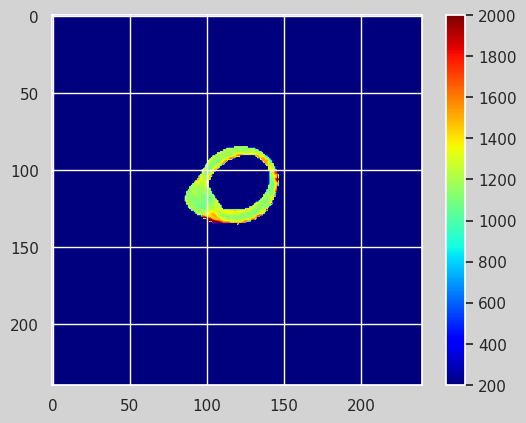

In [92]:
fig, ax = plt.subplots()
plt.imshow(masked_T1.filled(fill_value=0), cmap='jet', vmin=200, vmax=2e3)
fig.set_facecolor('lightgray')
plt.colorbar()

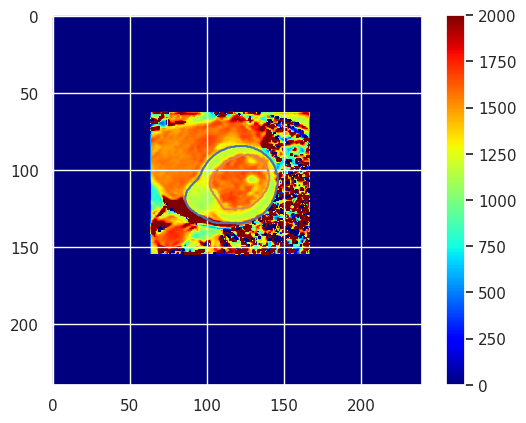

In [86]:
plt.imshow(data['T1'], cmap='jet', vmin=0, vmax=2000)
plt.colorbar()
x = [point[0] for point in data['outer_contour']]
y = [point[1] for point in data['outer_contour']]

# Plot the contour
plt.plot(x, y)

x = [point[0] for point in data['inner_contour']]
y = [point[1] for point in data['inner_contour']]

# Plot the contour
plt.plot(x, y)

In [124]:
X_test,time_tensor_unsorted, data_reshaped = get_data_stack(data)
nonzero_indices = np.nonzero(data['T1'])
top = np.min(nonzero_indices[0])
bottom = np.max(nonzero_indices[0])
left = np.min(nonzero_indices[1])
right = np.max(nonzero_indices[1])
height = bottom - top + 1
width = right - left + 1

# Compute the center crop dimensions
crop_size = min(height, width)
crop_top = top + (height - crop_size) // 2
crop_bottom = crop_top + crop_size - 1
crop_left = left + (width - crop_size) // 2
crop_right = crop_left + crop_size - 1

In [126]:
data_reshaped.shape

torch.Size([57600, 11])

In [127]:
X_test = torch.stack([time_tensor.unsqueeze(0).repeat(data_tensor.shape[0]* data_tensor.shape[1], 1), data_reshaped_perturbed], dim=2)


IndexError: tuple index out of range

In [128]:
X_test.shape

torch.Size([57600, 11, 2])

In [ ]:
#X_test = torch.stack([time_tensor.unsqueeze(0).repeat(data_tensor.shape[0]* data_tensor.shape[1], 1), data_reshaped], dim=2)
i = 1
print('now the perturabation std is ', (i+1)*5)
data_reshaped_perturbed = data_reshaped + torch.randn_like(data_reshaped) * 5*(i+1)
#test_X = data_reshaped_perturbed
X_test = torch.stack([time_tensor.unsqueeze(0).repeat(data_tensor.shape[0]* data_tensor.shape[1], 1), data_reshaped_perturbed], dim=2)

fitted_params = torch.Tensor(np.load(f'/mnt/vol6t/Projects/curve_fit/PyMC/output_data_perturb/2980827_20140416_MOLLI_pre_groupwise.mat_slice_1_perturb_{5*(i+1)}.npy'))
fitted_params = fitted_params.reshape(-1, 3)
######################
# Validation
######################
test_X = X_test
test_y = fitted_params
test_X_norm = test_X/torch.Tensor([2000,200])
#test_y_norm = test_y/torch.Tensor([100,1,1000])
#test_time_norm = test_time/1000

model.eval()

test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(test_X_norm)
test_coeffs = test_coeffs.cuda()
test_y = test_y.cuda()

test_dataset = torch.utils.data.TensorDataset(test_coeffs, test_y)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2048)

text_X_norm_mlp = test_X_norm.reshape(-1,22)
test_dataset_mlp = torch.utils.data.TensorDataset(text_X_norm_mlp.cuda(), test_y)
test_dataloader_mlp = torch.utils.data.DataLoader(test_dataset_mlp, batch_size=65536)



val_prediction_mlp_ensemble = []
for model_2 in models:
    model_2.eval()
    val_loss = []
    val_prediction_mlp = []
    for batch in tqdm(test_dataloader_mlp):
        batch_x, batch_y, = batch
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        pred_y = model_2(batch_x).squeeze(-1)
        loss = nn.functional.l1_loss(pred_y, batch_y)
        # rescale pred_y to the original scale
        pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
        val_prediction_mlp.append(pred_y)
        val_loss.append(loss.item())
    val_prediction_mlp = torch.cat(val_prediction_mlp, dim=0)[:,2]
    val_prediction_mlp = val_prediction_mlp.cpu().detach().numpy()
    val_prediction_mlp_ensemble.append(val_prediction_mlp)

val_prediction_mlp_ensemble = np.mean(val_prediction_mlp_ensemble, axis = 0)

val_loss = np.array(val_loss)
print(val_loss.mean())

######################
# Plotting
######################
fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=300)
fig.suptitle(f'T1 Mapping at Gaussian Noise Level {(i+1)*5}', x = 0.56, y = 0.72)
im = ax1.imshow(fitted_params.reshape(256,256,3)[:,:,2], vmin=200, vmax=2e3, cmap='jet')
ax1.set_title('LS - T1 (ms)', y = -0.2)
ax1.axis('off')

plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax2.imshow(val_prediction_mlp.reshape(256,256), cmap='jet', vmin=200, vmax=2e3)
ax2.axis('off')
ax2.set_title('MLP - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax3.imshow(val_prediction_mlp_ensemble.reshape(256,256), cmap='jet', vmin=200, vmax=2e3)
ax3.axis('off')
ax3.set_title('MLP - mean over 5 ckpts - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

# arrange mask for visualization and real evaluation

val_prediction_mlp = val_prediction_mlp.reshape(data['T1'].shape[0],data['T1'].shape[1])
masked_mlp = np.ma.masked_array(val_prediction_mlp, mask = 1-data['T1'].astype('bool'), fill_value= 0)[crop_top:crop_bottom+1, crop_left:crop_right+1]
masked_mlp_myo = np.ma.masked_array(val_prediction_mlp, mask = 1-data['mask'].astype('int'), fill_value= 0)[crop_top:crop_bottom+1, crop_left:crop_right+1]

val_prediction_mlp_ensemble = val_prediction_mlp_ensemble.reshape(data['T1'].shape[0],data['T1'].shape[1])
masked_ensemble = np.ma.masked_array(val_prediction_mlp_ensemble, mask = 1-data['T1'].astype('bool'), fill_value= 0)[crop_top:crop_bottom+1, crop_left:crop_right+1]
masked_ensemble_myo = np.ma.masked_array(val_prediction_mlp_ensemble, mask = 1-data['mask'].astype('int'), fill_value= 0)[crop_top:crop_bottom+1, crop_left:crop_right+1]

masked_T1_myo = np.ma.masked_array(data['T1'], mask = 1-data['mask'].astype('int'), fill_value= 0)[crop_top:crop_bottom+1, crop_left:crop_right+1]

masked_T1_myo_perturb = np.ma.masked_array(fitted_params[:,2].reshape(data['T1'].shape[0],data['T1'].shape[1]), mask = 1-data['mask'].astype('int'), fill_value= 0)[crop_top:crop_bottom+1, crop_left:crop_right+1]


diff_myo_ls_mlp = abs(masked_mlp_myo - masked_T1_myo)
diff_myo_ls_ensemble = abs(masked_ensemble_myo - masked_T1_myo)
diff_myo_ls_self_perturb = abs(masked_T1_myo_perturb - masked_T1_myo)

T1_ls_mean = masked_T1_myo.mean()
T1_ls_perturb_mean = masked_T1_myo_perturb.mean()
T1_mlp_mean = masked_mlp_myo.mean()
T1_ensemble_mean = masked_ensemble_myo.mean()
T1_ls_sd = masked_T1_myo.std()
T1_ls_perturb_sd = masked_T1_myo_perturb.std()
T1_mlp_sd = masked_mlp_myo.std()
T1_ensemble_sd = masked_ensemble_myo.std()
print(diff_myo_ls_self_perturb.mean(),diff_myo_ls_mlp.mean(), diff_myo_ls_ensemble.mean())
print(T1_ls_mean, T1_ls_perturb_mean, T1_mlp_mean, T1_ensemble_mean)
print(T1_ls_sd, T1_ls_perturb_sd,T1_mlp_sd, T1_ensemble_sd)

In [ ]:
masked_ensemble_myo.compressed()[masked_ensemble_myo.compressed()<2000].std()

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=300)
fig.suptitle(f'T1 Mapping at Gaussian Noise Level {(i+1)*5}', x = 0.56, y = 0.72)
im = ax1.imshow(fitted_params.reshape(256,256,3)[:,:,2], vmin=200, vmax=2e3, cmap='jet')
ax1.set_title('LS - T1 (ms)', y = -0.2)
ax1.axis('off')

plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax2.imshow(val_prediction_mlp.reshape(256,256), cmap='jet', vmin=200, vmax=2e3)
ax2.axis('off')
ax2.set_title('MLP - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

im = ax3.imshow(val_prediction_mlp_ensemble.reshape(256,256), cmap='jet', vmin=200, vmax=2e3)
ax3.axis('off')
ax3.set_title('MLP - mean over 5 ckpts - T1 (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.025)

In [ ]:
print(masked_T1_myo.max(),masked_T1_myo_perturb.max())

In [ ]:
print(np.mean(masked_T1_myo[masked_T1_myo<3000]), np.mean(masked_T1_myo_perturb[masked_T1_myo_perturb<3000]))

In [ ]:
masked_T1_myo.compressed()[masked_T1_myo.compressed()<3000].std()

In [ ]:
masked_ensemble_myo.compressed()[masked_ensemble_myo.compressed()<3000].std()

In [ ]:
# The average may not be objective - need to mask again...:
sns.set_theme()
plt.hist(masked_T1_myo[masked_T1_myo<100000], bins = 100, alpha = 0.5, label = 'T1 LS')

In [ ]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4, dpi=300)
fig.suptitle(f'T1 Mapping - Noise Level {(i+1)*5} - Myocardium Only', y = 0.67)
im = ax0.imshow(masked_T1_myo.filled(0), vmin=200, vmax=2e3, cmap='jet')
ax0.set_title(f'Original - T1 (ms) \n mean = {masked_T1_myo.mean():.2f}', y = -0.5, fontsize = 9)
ax0.axis('off')

plt.colorbar(im, fraction=0.045, pad=0.025)

im = ax1.imshow(masked_T1_myo_perturb.filled(0), vmin=200, vmax=2e3, cmap='jet')
ax1.set_title(f'LS - T1 (ms) \n mean = {masked_T1_myo_perturb.mean():.2f}', y = -0.5, fontsize = 9)
ax1.axis('off')

plt.colorbar(im, fraction=0.045, pad=0.025)

im = ax2.imshow(masked_mlp_myo.filled(0), cmap='jet', vmin=200, vmax=2e3)
ax2.axis('off')
ax2.set_title(f'MLP - T1 (ms) \n mean = {masked_mlp_myo.mean():.2f}', y = -0.5, fontsize = 9)
plt.colorbar(im, fraction=0.045, pad=0.025)

im = ax3.imshow(masked_ensemble_myo.filled(0), cmap='jet', vmin=200, vmax=2e3)
ax3.axis('off')
ax3.set_title(f'Ensemble - T1 (ms) \n mean = {masked_ensemble_myo.mean():.2f}', y = -0.5, fontsize = 9)
plt.colorbar(im, fraction=0.045, pad=0.025)

fig.tight_layout()

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, dpi=300)
fig.suptitle(f'T1 Mapping Difference - Noise Level {(i+1)*5} - Myocardium Only \n', y = 0.7)
'''
im = ax0.imshow(masked_T1_myo.filled(0), vmin=200, vmax=2e3, cmap='jet')
ax0.set_title(f'LS - T1 (ms) \n mean = {masked_T1_myo.mean():.2f}', y = -0.3, fontsize = 9)
ax0.axis('off')
plt.colorbar(im, fraction=0.045, pad=0.025)
'''
extent = 100
im = ax1.imshow(-(masked_T1_myo.filled(0) - masked_T1_myo_perturb.filled(0)), cmap='RdBu', vmin=-extent, vmax=extent)
ax1.set_title(f'(LS_perturb - LS ) - T1 (ms) \n MAE = {diff_myo_ls_self_perturb.mean():.2f}', y = -0.3, fontsize = 9)
ax1.axis('off')

plt.colorbar(im, fraction=0.045, pad=0.025)

im = ax2.imshow(-(masked_T1_myo.filled(0) - masked_mlp_myo.filled(0)), cmap='RdBu', vmin=-extent, vmax=extent)
ax2.axis('off')
ax2.set_title(f'(MLP - LS) - T1 (ms) \n MAE = {diff_myo_ls_mlp.mean():.2f}', y = -0.3, fontsize = 9)
plt.colorbar(im, fraction=0.045, pad=0.025)

im = ax3.imshow(-(masked_T1_myo.filled(0) - masked_ensemble_myo.filled(0)), cmap='RdBu', vmin=-extent, vmax=extent)
ax3.axis('off')
ax3.set_title(f'(Ensemble - LS) - T1 (ms) \n MAE = {diff_myo_ls_ensemble.mean():.2f}', y = -0.3, fontsize = 9)
plt.colorbar(im, fraction=0.045, pad=0.025)


In [ ]:
plt.hist(masked_T1_myo)

# Ensemble - MC experiments for analysing the bias

In [4]:
# we first need to confirm whether the model itself is biased when 
# predicting the T1 values when generated

In [ ]:
model_2 = MLP(input_channels=22, hidden_channels=128, output_channels=3)
model_2 = model_2.cuda()
model_2.load_state_dict(torch.load('/mnt/vol6t/Projects/NeuralCDE/T1_mapping/scripts/wandb/run-20230510_170542-87cqpdoh/files/model_at_epoch_36.pt'))

In [5]:
model_2 = MLP_myomapnet(input_channels=22, hidden_channels=400, output_channels=3)
model_2 = model_2.cuda()
model_2.load_state_dict(torch.load('/mnt/vol6t/Projects/NeuralCDE/T1_mapping/scripts/wandb/run-20230515_152030-toba5m1z/files/model_at_epoch_51.pt'))

<All keys matched successfully>

In [6]:
# generate data
val_X, val_y, val_time = get_data_seq(dataset_size=50000, fixed= 1, t_perturb= 1, varying_length=1, rician = 1)
val_X_norm = val_X.clone()
val_y_norm = val_y.clone()
val_time_norm = val_time.clone()
val_X_norm = val_X_norm/torch.Tensor([1000,100])
val_time_norm = val_time_norm/torch.Tensor([1000])
val_y_norm = val_y_norm/torch.Tensor([100,1,1000])
val_X_norm = (val_X_norm).reshape([-1,22])
val_dataset = torch.utils.data.TensorDataset(val_X_norm, val_y_norm)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)



100%|██████████| 50000/50000 [01:12<00:00, 692.29it/s]


In [15]:
# generate data
val_X, val_y, val_time = get_data_seq(dataset_size=20000, fixed= 1, t_perturb= 1, varying_length=1)
val_X_norm = val_X.clone()
val_y_norm = val_y.clone()
val_time_norm = val_time.clone()
val_X_norm = val_X_norm/torch.Tensor([2000,200])
val_time_norm = val_time_norm/torch.Tensor([2000])
val_y_norm = val_y_norm/torch.Tensor([100,1,1000])
val_X_norm = (val_X_norm).reshape([-1,22])
val_dataset = torch.utils.data.TensorDataset(val_X_norm, val_y_norm)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)



100%|██████████| 20000/20000 [00:02<00:00, 7823.81it/s]


In [16]:
def validation(model, loss_func, test_dataloader, epoch):
    # validation is done by an iteration over set of images AND generated sequences

    model.eval()
    val_loss = []
    val_prediction = []
    for batch in tqdm(test_dataloader):
        batch_coeffs, batch_y, = batch
        batch_coeffs = batch_coeffs.cuda()
        batch_y = batch_y.cuda()
        pred_y = model(batch_coeffs).squeeze(-1)
        # rescale pred_y to the original scale
        pred_y = pred_y*(torch.Tensor([100,1,1000]).cuda())
        loss_MAE = nn.functional.l1_loss(pred_y, batch_y)
        #loss_PINN = loss_func(pred_y, batch_y,torch.linspace(0,4000,100).cuda())
        #print(loss_PINN)
        loss = loss_MAE
        #wandb.log({'step_loss_val_MAE': loss_MAE})
        #wandb.log({'step_loss_val_PINN': loss_PINN})
        #wandb.log({"step_loss_val": loss})
        val_loss.append(loss.item())
        val_prediction.append(pred_y)

    val_loss = np.array(val_loss)
    val_prediction = torch.cat(val_prediction, dim=0)[:,2]
    val_prediction = val_prediction.cpu().detach().numpy()
    #wandb.log({"epoch_loss_val": val_loss.mean(), "epoch": epoch})

    return val_prediction

In [17]:
val_prediction = validation(model = model_2, test_dataloader = val_dataloader, loss_func = None, epoch = 0)


100%|██████████| 79/79 [00:00<00:00, 574.00it/s]


In [18]:
sns.set_theme()

(array([2010., 2097., 1942., 2012., 1985., 1972., 2020., 1976., 2011.,
        1975.]),
 array([ 100.11315155,  340.06427002,  580.01538086,  819.9664917 ,
        1059.91760254, 1299.86865234, 1539.81982422, 1779.77087402,
        2019.7220459 , 2259.6730957 , 2499.62426758]),
 <BarContainer object of 10 artists>)

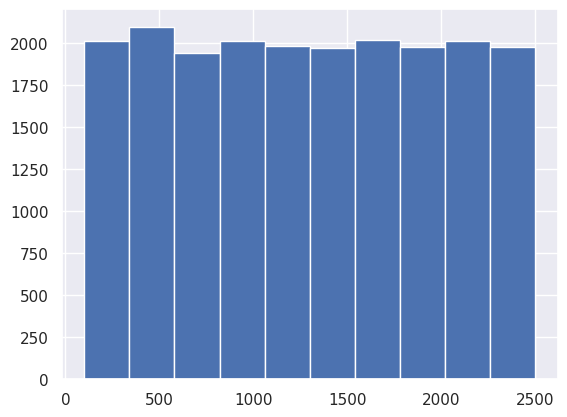

In [19]:
plt.hist(val_y[:,2])

(array([ 88., 241., 243., 233., 207., 203., 194., 218., 213., 197., 201.,
        223., 201., 221., 208., 226., 176., 220., 216., 225., 196., 208.,
        185., 217., 198., 201., 190., 191., 190., 220., 203., 221., 225.,
        196., 214., 201., 200., 189., 223., 220., 211., 202., 196., 193.,
        196., 238., 206., 190., 201., 213., 215., 173., 188., 200., 189.,
        196., 206., 223., 220., 206., 214., 207., 229., 203., 192., 202.,
        220., 210., 195., 202., 193., 225., 200., 215., 185., 197., 214.,
        222., 179., 229., 215., 215., 207., 224., 217., 217., 201., 186.,
        216., 218., 216., 215., 248., 245., 232., 181.,  85.,  21.,   3.,
          1.]),
 array([  95.18486023,  119.83937836,  144.49389648,  169.14842224,
         193.80293274,  218.4574585 ,  243.11196899,  267.76647949,
         292.42102051,  317.07553101,  341.7300415 ,  366.384552  ,
         391.03909302,  415.69360352,  440.34811401,  465.00262451,
         489.65716553,  514.31170654,  538.966

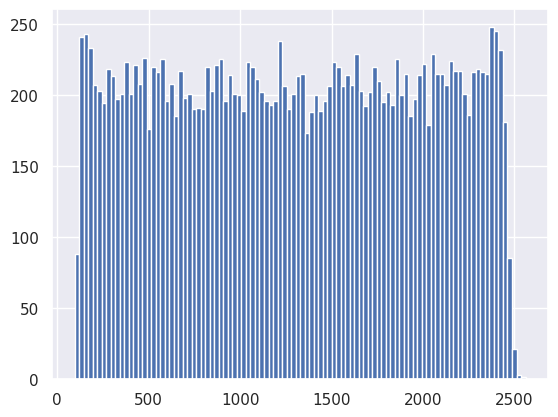

In [20]:
plt.hist(val_prediction[abs(val_prediction)<1e4], bins = 100)

(array([1.0000e+00, 7.0000e+00, 4.0000e+00, 1.7000e+01, 3.6000e+01,
        8.8100e+02, 1.8944e+04, 8.7000e+01, 1.8000e+01, 5.0000e+00]),
 array([-1880.10693359, -1575.53491211, -1270.96289062,  -966.39093018,
         -661.81896973,  -357.24694824,   -52.67494965,   251.89704895,
          556.46905518,   861.04101562,  1165.61303711]),
 <BarContainer object of 10 artists>)

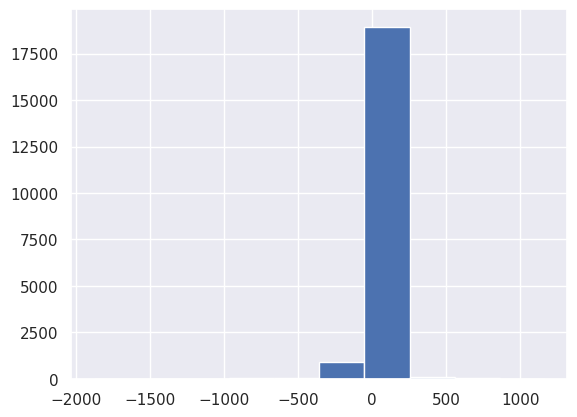

In [21]:
plt.hist((val_y[:,2]-val_prediction)[abs(val_prediction)<1e5])
#val_prediction

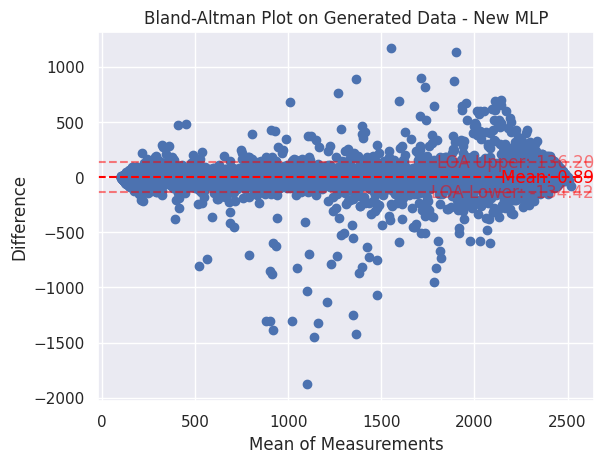

In [22]:
array1 = np.array(val_y[:,2])
array2 = np.array(val_prediction)

mean_diff = np.mean(array1 - array2)
diff = array1 - array2
mean = np.mean(diff)
sd = np.std(diff)
loa_lower = mean - 1.96 * sd
loa_upper = mean + 1.96 * sd

# Create Bland-Altman plot
plt.scatter(np.mean([array1, array2], axis=0), diff)
plt.axhline(mean, color='red', linestyle='--')
plt.axhline(loa_lower, color='red', linestyle='--', alpha=0.5)
plt.axhline(loa_upper, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Mean of Measurements')
plt.ylabel('Difference')
plt.title('Bland-Altman Plot on Generated Data - New MLP')
plt.text(plt.xlim()[1], mean, f'Mean: {mean:.2f}', ha='right', va='center', color='red')
plt.text(plt.xlim()[1], loa_lower, f'LOA Lower: {loa_lower:.2f}', ha='right', va='center', color='red', alpha=0.5)
plt.text(plt.xlim()[1], loa_upper, f'LOA Upper: {loa_upper:.2f}', ha='right', va='center', color='red', alpha=0.5)

plt.show()

# Weight Similarity

In [43]:
import itertools
models = []
#naive loss
model_folder = ['run-20230515_152030-toba5m1z','run-20230515_184020-45p69r30','run-20230515_183956-4celg5pb','run-20230515_184050-5lcse0fj']
#3-param loss
#model_folder = ['run-20230531_183513-lc7so1vv']
#3-param loss + PINN loss
model_folder = ['run-20230601_142526-zflbb6nd']
model_epochs = [16]#
                #26, 36, 46, 56, 66, 76, 86, 96]
model_paths = []
for i,j in itertools.product(model_folder, model_epochs):
    model_paths.append(f'/mnt/vol6t/Projects/NeuralCDE/T1_mapping/scripts/wandb/{i}/files/model_at_epoch_{j}.pt')

for i, model_path in enumerate(model_paths):
    print(i)
    models.append( MLP_myomapnet(input_channels=22, hidden_channels=400, output_channels=3))
    #models[i] = models[i].cuda()
    models[i].load_state_dict(torch.load(model_path))

0


In [44]:
flattened_weights_models = []
for i in range(len(models)):
    flattened_weights = []


    # Iterate over the parameters of the model
    for param in models[i].parameters():
        # Flatten the parameter tensor
        flattened_param = param.flatten()
        
        # Convert the flattened tensor to a numpy array
        np_param = flattened_param.detach().numpy()
        
        # Append the numpy array to the list of flattened weights
        flattened_weights.append(np_param)

    # Concatenate all the flattened weights in the list
    flattened_tensor = torch.from_numpy(np.concatenate(flattened_weights))

    # Print the flattened tensor
    print(flattened_tensor)
    flattened_weights_models.append(flattened_tensor)

tensor([-0.7715,  0.1533, -0.3764,  ...,  0.9408, -0.4358, -0.3324])


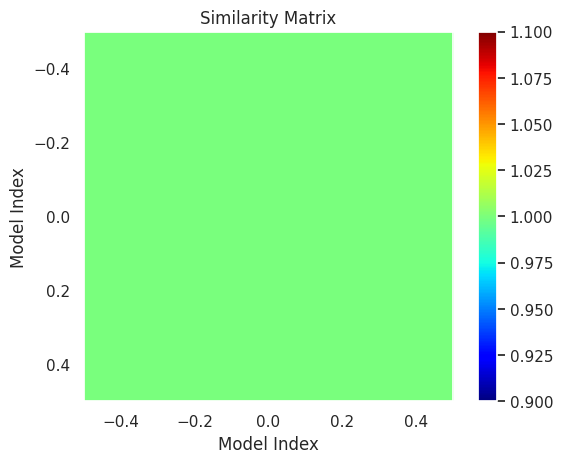

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn theme
sns.set_theme()

import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a list of flat tensors called `flat_tensors`
# Calculate the pairwise similarity matrix using cosine similarity
num_tensors = len(flattened_weights_models)
similarity_matrix = np.zeros((num_tensors, num_tensors))

for i in range(num_tensors):
    for j in range(num_tensors):
        similarity_matrix[i, j] = np.dot(flattened_weights_models[i], flattened_weights_models[j]) / (np.linalg.norm(flattened_weights_models[i]) * np.linalg.norm(flattened_weights_models[j]))

# Plot the similarity matrix
plt.imshow(similarity_matrix, cmap='jet', interpolation='nearest')
plt.colorbar()
plt.title('Similarity Matrix')
plt.xlabel('Model Index')
plt.ylabel('Model Index')
plt.grid(False)
plt.show()


# LS outlier - fitting test

In [46]:
import glob

# generate inference data numpy - now we have the perturbed data
data_root = '/mnt/vol6t/Projects/NeuralCDE/T1_mapping/registered_dataset'
data_files = glob.glob(data_root + '/6263556_20131023_MOLLI_pre_groupwise_slice1_org.pt')
data = torch.load(data_files[0])
masked_T1 = np.ma.masked_array(data['T1'], mask = 1-data['mask'].astype('int'), fill_value= 0)
max_pos = np.unravel_index(np.argmax(masked_T1), masked_T1.shape)


In [47]:
masked_T1.max()

3417.030993999717

In [48]:
data['volume'][max_pos[0],max_pos[1],:]

array([85.78913116, 15.32994843, 35.84799194, 62.93899918, 13.79642677,
        5.39936399, 41.54579926, 13.06985378, 13.16138935, 17.61820412,
       15.20213985])

In [49]:
from scipy.optimize import curve_fit

def T1_3param(t, C, k, T1):
    '''
    MOLLI signal acquistion equation s(t) = C(1 - k * np.exp(-t*(k-1)/T1))
    '''
    return np.abs(C*(1 - k * np.exp(-t*(k-1)/T1)))

def polarity_recovery(signal, tvec, p0=None, signal_threshold=25,
                      cache=None, cache_result=True,
                      **kwargs):
    '''
    Polarity recovery fitting, using cache can achieve an acceleration factor
    of ~2. 

    Parameters
    ----------
    signal : numpy.array
        signal acquisition array of shape (#acquisitions, )
    tvec : numpy.array
        inverstion time array of shape (#acquisitions, )
    signal_threshold : float
        threshold of maximal signal intensity, no protons will be assumed if max(signal) < threshold
    cache : List[dict]
        List of cached polarity recovery fitting results, for example results
        from the neignbouring voxels.
    cache_result : bool
        if the fitting intermediate results should be cached
    **kwargs 
        parameters that can be passed to curve fit
    
    '''
    # make safe code 
    signal = signal.squeeze().astype(np.float64)
    tvec = tvec.squeeze().astype(np.float64)
    
    # a few checks before running
    assert np.all(tvec[1:] - tvec[:-1] >= -1e-8), "Time vector is not sorted!"
    assert signal.shape == tvec.shape, "signal and tvec have mismatching shape!"
    
    # early exit 
    if signal.max() < signal_threshold: 
        return dict(p_opt=np.array([1., 0., 0.]), p_cov=None,
                    null_index=0, sd = 0, cache=None)
    
    # adaptively initialize p0 
    if p0 is None:
        p0 = np.array([signal.max(), 2.0, 1e3])
    if cache is None:
        cache = [dict(p_opt=p0) for _ in tvec]
    assert len(cache) == tvec.shape[0], "cache has incorrect shape!"
    
    opt_results = []
    fitting_errors = [] 
    
    # polarity recovery 
    for null_index in range(signal.shape[-1]):
        signal_inverted = signal.copy()    #copy the array to avoid in-place change
        signal_inverted[:null_index] *= -1
        try:
            # ensure p0 is valid
            p0 = cache[null_index]["p_opt"]
            if kwargs.get("bounds") is not None:
                p0 = np.clip(p0, kwargs['bounds'][0], kwargs['bounds'][1])
            
            # optimize!
            p_opt, p_cov  = curve_fit(T1_3param, tvec, signal_inverted,
                                      p0=p0,
                                      bounds=(0, (abs(y.max()+1) * 20., 30., 10e4)))
            
            # evaluate the mse error
            signal_fitted = T1_3param(tvec, *p_opt)
            mse = np.mean((signal_fitted - signal_inverted) ** 2)
        except Exception as e:
            print(cache[null_index]["p_opt"])
            print(kwargs)
            # handle the exception and indicate when the error is raised
            raise type(e)(str(e) + f"\nError raised when null_index={null_index:d}") 
       
        # save intermediate fitting results 
        opt_results.append(dict(p_opt=p_opt,
                                p_cov=p_cov,
                                mse=mse))
        fitting_errors.append(mse) 

    # find the best one
    best_null_index = np.argmin(fitting_errors) 
    best_opt_result = opt_results[best_null_index]
    best_opt_result["null_index"] = best_null_index

    signal_invert = signal.copy()
    signal[:best_null_index] = -1*signal[:best_null_index]
    #best_opt_result['sd'] = sd_calculation(best_opt_result['p_opt'], tvec, signal_invert)
    # cache results if necessary 
    best_opt_result["cache"] = opt_results if cache_result else None 
    return best_opt_result

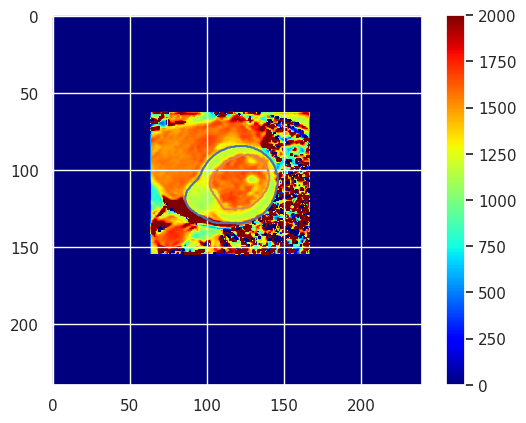

In [50]:
plt.imshow(data['T1'], cmap='jet', vmin=0, vmax=2000)
plt.colorbar()
x = [point[0] for point in data['outer_contour']]
y = [point[1] for point in data['outer_contour']]

# Plot the contour
plt.plot(x, y)

x = [point[0] for point in data['inner_contour']]
y = [point[1] for point in data['inner_contour']]

# Plot the contour
plt.plot(x, y)


In [51]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function to fit

def T1_3param(t, C, k, T1):
    '''
    MOLLI signal acquistion equation s(t) = C(1 - k * np.exp(-t*(k-1)/T1))
    '''
    return C*(1 - k * np.exp(-t*(k-1)/T1))

# Generate some example data
#seq_to_be_fit = data['volume'][max_pos[0],max_pos[1],:]
seq_to_be_fit = data['volume'][100,125,:]

x = data['tvec'].astype('float32')

x = data['tvec'].astype('float32')
y = seq_to_be_fit



time_tensor = torch.Tensor(data['tvec'].astype('float32'))
time_tensor, index = torch.sort(time_tensor)
data_tensor = torch.Tensor(seq_to_be_fit.astype('float32'))
x = x[index]
y = y[index]
X_test = torch.stack([time_tensor.unsqueeze(0), data_tensor.unsqueeze(0)], dim=2)
X_test = X_test/torch.Tensor([2000,200])
X_test = X_test.reshape(-1,22)

# Perform the curve fitting
#popt, pcov = curve_fit(T1_3param, x, y, p0 = np.array([y.max(), 3.0, 1e3]),bounds=(0, (abs(y.max()+1) * 20., 30., 10e4)))
popt = polarity_recovery(y, x, p0 = np.array([y.max(), 2.0, 1e3]),bounds=(0, (abs(y.max()+1) * 20., 30., 1e4)))
# Retrieve the optimized parameters
print(popt['p_opt'])



[ 216.97831616    2.09672833 1639.20637084]


In [52]:
color_list = ['g-', 'b-', 'y-', 'm-']

In [53]:
popt['p_opt'][0]

216.97831615889248

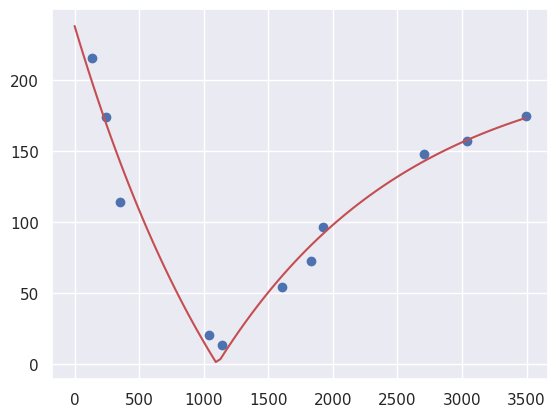

In [54]:
y_fit = np.abs(T1_3param(np.linspace(0,3500,100), popt['p_opt'][0], popt['p_opt'][1], popt['p_opt'][2]))

# Plot the original data and the fitted curve
plt.plot(x, y, 'bo', label='Original Data')
plt.plot(np.linspace(0,time_tensor.max(),100), y_fit, 'r-', label='Fitted Curve')


tensor([[ 183.3206,    2.4786, 1560.4625]], grad_fn=<MulBackward0>)


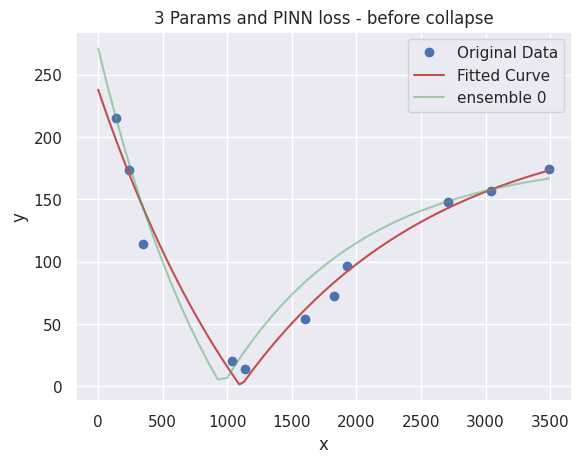

In [56]:
# Generate the fitted curve using the optimized parameters
y_fit = np.abs(T1_3param(np.linspace(0,3500,100), popt['p_opt'][0], popt['p_opt'][1], popt['p_opt'][2]))

# Plot the original data and the fitted curve
plt.plot(x, y, 'bo', label='Original Data')
plt.plot(np.linspace(0,time_tensor.max(),100), y_fit, 'r-', label='Fitted Curve')


for i in range(len(models)):
    
    models[i].eval()
    y_pred = models[i](X_test)*torch.Tensor([100,1,1000])
    print(y_pred)
    y_pred = np.abs(T1_3param(np.linspace(0,time_tensor.max(),50), y_pred[0,0].detach().numpy(), y_pred[0,1].detach().numpy(), y_pred[0,2].detach().numpy()))
    plt.plot(np.linspace(0,time_tensor.max(),50), y_pred, color_list[i//9],  label = str(f'ensemble {(i+1)//9}'),alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
#T1 = data['T1'][max_pos[0],max_pos[1]]
#plt.title(f'Original Data and Fitted Curve, T1 = {T1}')

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
  if label not in newLabels:
    newLabels.append(label)
    newHandles.append(handle)
plt.legend(newHandles, newLabels)
plt.title('3 Params and PINN loss - before collapse')
plt.show()

In [21]:
data['T1'][max_pos[0],max_pos[1]]

3417.030993999717